# Importing libraries and reading source files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy

In [2]:
# Source files
brands=pd.read_csv(r'C:\Users\hello\OneDrive\ME\ME\LEARNING\Python\Projects\Bikers club\Bikers\brands.csv',index_col='brand_id')
categories=pd.read_csv(r'C:\Users\hello\OneDrive\ME\ME\LEARNING\Python\Projects\Bikers club\Bikers\categories.csv',index_col='category_id')
customers=pd.read_csv(r'C:\Users\hello\OneDrive\ME\ME\LEARNING\Python\Projects\Bikers club\Bikers\customers.csv',index_col='customer_id')
orders=pd.read_csv(r'C:\Users\hello\OneDrive\ME\ME\LEARNING\Python\Projects\Bikers club\Bikers\orders.csv',index_col='order_id')
order_items=pd.read_csv(r'C:\Users\hello\OneDrive\ME\ME\LEARNING\Python\Projects\Bikers club\Bikers\order_items.csv')
products=pd.read_csv(r'C:\Users\hello\OneDrive\ME\ME\LEARNING\Python\Projects\Bikers club\Bikers\products.csv',index_col='product_id')
staffs=pd.read_csv(r'C:\Users\hello\OneDrive\ME\ME\LEARNING\Python\Projects\Bikers club\Bikers\staffs.csv',index_col='staff_id')
stores=pd.read_csv(r'C:\Users\hello\OneDrive\ME\ME\LEARNING\Python\Projects\Bikers club\Bikers\stores.csv',index_col='store_id')

# CONVERTING Object data type into datetime64 (for time series Analysis)
orders['order_date']=pd.to_datetime(orders['order_date'])
orders['shipped_date']=pd.to_datetime(orders['shipped_date'])
orders['required_date']=pd.to_datetime(orders['required_date'])

# editing in staff table
staffs=staffs.drop('active',axis=1)
staffs=staffs.drop('manager_id',axis=1)

# adding total sale value-revenue
revenue_formula=(order_items['quantity']*order_items['list_price'])-(order_items['discount']*order_items['quantity'])
order_items=order_items.assign(revenue=revenue_formula)

In [6]:
# Transferring Dataframes to SQL (MYSQL)
# DO NOT TOUCH THIS
#from sqlalchemy import create_engine
#username = 'root'          # MySQL username
#password = 'Patine5833'  # MySQL password
#host = 'localhost'         # Database host (localhost in this case)
#port = 3306                # MySQL port (default is 3306)
#database = 'Bikers_club'        # The name of the database you want to connect to

 # SQLAlchemy engine
#engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

# Transferring dataframes
#brands.to_sql(name='brands', con=engine, if_exists='replace', index=True)
#categories.to_sql(name='categories', con=engine, if_exists='replace', index=True)
#customers.to_sql(name='customers', con=engine, if_exists='replace', index=True)
#orders.to_sql(name='orders', con=engine, if_exists='replace', index=True)
#order_items.to_sql(name='order_items', con=engine, if_exists='replace', index=True)
#products.to_sql(name='products', con=engine, if_exists='replace', index=True)
#staffs.to_sql(name='staffs', con=engine, if_exists='replace', index=True)
#stores.to_sql(name='stores', con=engine, if_exists='replace', index=True)

# Insights

In [3]:
# Insight 1
# Total revenue, orders and Average order value

total_revenue=order_items['revenue'].sum().round(2)
total_orders=order_items['order_id'].unique().size
Average_order_value=(total_revenue/total_orders).round(2)
print(f'Total Revenue: {total_revenue}\n'
      f'Total orders: {total_orders}\n'
      f'AOV: {Average_order_value}')

Total Revenue: 8578243.8
Total orders: 1615
AOV: 5311.61


,order_id,customer_id,full_name,total_order_value
0,1541,10,Pamelia Newman,32328.18
1,937,73,Melanie Hayes,29150.09
2,1506,75,Abby Gamble,28499.40
3,1364,122,Shena Carter,27618.51
4,1482,94,Sharyn Hopkins,26989.49
5,930,1224,Abram Copeland,26913.31
6,1118,1023,Adena Blake,22999.02
7,1348,1214,Brigid Sharp,22299.58
8,1277,227,Danielle Bond,21999.92
9,973,238,Cindi Larson,21816.36


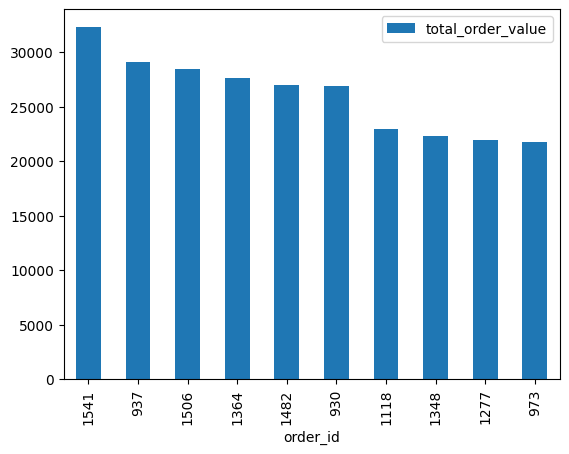

In [4]:
# Insight 2
# Biggest Orders

# Finding 10 buggest orders
Merge1=orders.merge(order_items,
                    how='inner',
                    on='order_id').loc[:,['order_id','customer_id','revenue']]
Merge1=Merge1.groupby(['order_id','customer_id'],as_index=False).agg(total_order_value=('revenue','sum'))\
                                                                .sort_values('total_order_value',ascending=False).head(10)

# Merging customer table to determine customers who placed those orders
Merge2=Merge1.merge(customers,
                    how='inner',
                    on='customer_id')
Merge2['full_name']=Merge2['first_name']+' '+Merge2['last_name']

# Required Dataframe
Merge2=Merge2.loc[:,['order_id','customer_id','full_name','total_order_value']]

# Visualisation
Merge2.loc[:,['order_id','total_order_value']].set_index('order_id').plot(kind='bar')
Merge2

,total_revenue,total_orders,AOV,Revenue_change_percent,orders_change_percent,AOV_change_percent
Year,,,,,,
2016,2709206.83,635,4266.47,NaN,NaN,NaN
2017,3845186.29,688,5588.93,41.93,8.35,31.00
2018,2023850.68,292,6931.00,-47.37,-57.56,24.01


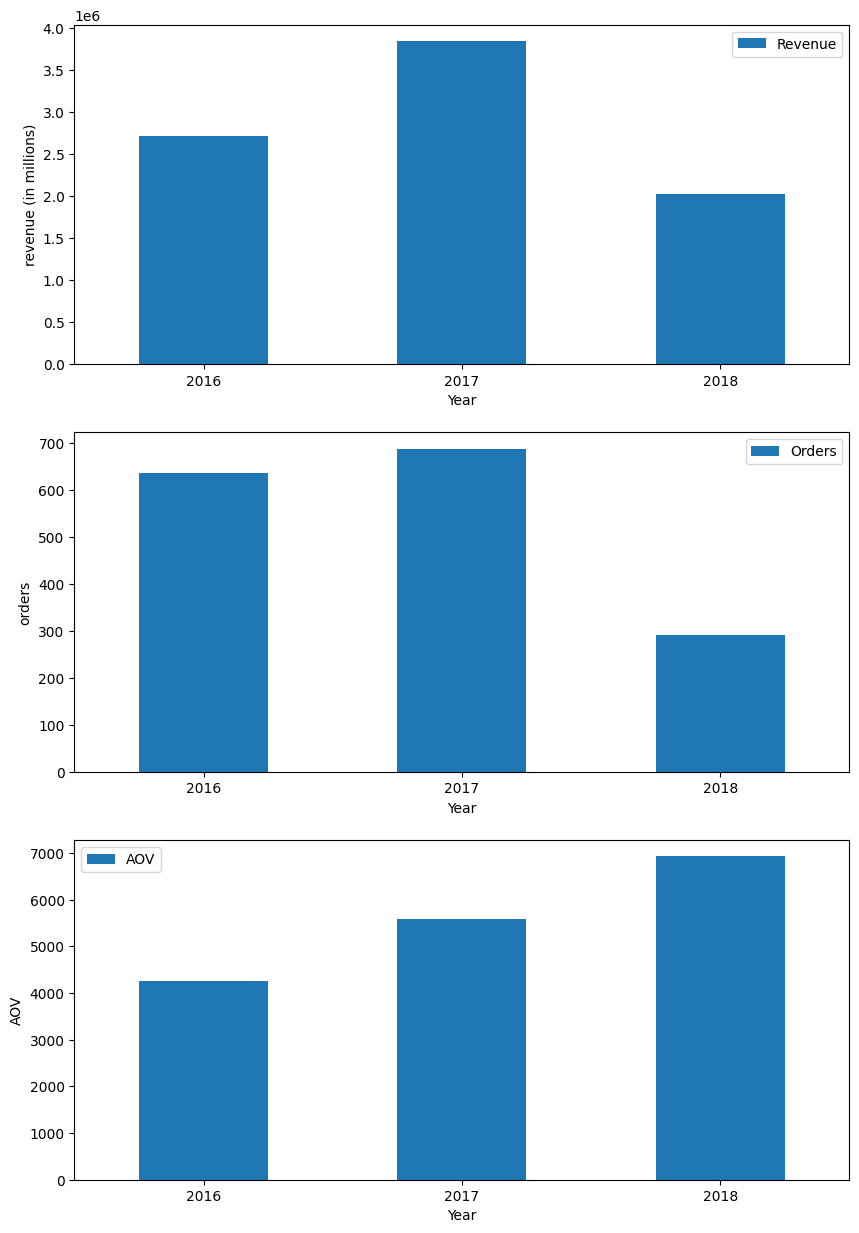

In [5]:
# Insight 3
# Yearly trend analysis

# Merging orders and order items table to calculate total revenue, total orders by years
Merge1=orders.merge(order_items,
                    how='inner',
                    on='order_id').loc[:,['order_id','order_date','revenue']]

Merge1=Merge1.assign(Year=Merge1['order_date'].dt.year)

Merge1=Merge1.groupby(['Year']).agg(total_revenue=('revenue','sum'),
                             total_orders=('order_id','nunique'))

# Creation of average order value column
Merge1=Merge1.assign(AOV=(Merge1['total_revenue']/Merge1['total_orders']).round(2))

# Variables for yearly change percent
Yearly_revenue_change=((Merge1['total_revenue']-Merge1['total_revenue'].shift())/Merge1['total_revenue'].shift()*100).round(2)
Yearly_order_change=((Merge1['total_orders']-Merge1['total_orders'].shift())/Merge1['total_orders'].shift()*100).round(2)
Yearly_AOV_change=((Merge1['AOV']-Merge1['AOV'].shift())/Merge1['AOV'].shift()*100).round(2)

# Creation of yearly change percent columns
Merge1=Merge1.assign(Revenue_change_percent=Yearly_revenue_change,
                     orders_change_percent=Yearly_order_change,
                     AOV_change_percent=Yearly_AOV_change)

# Required dataframe
Merge1.loc[:,['total_revenue','Revenue_change_percent','total_orders','orders_change_percent','AOV','AOV_change_percent']]

# Visualisation
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
Merge1['total_revenue'].plot(kind='bar',label='Revenue')
plt.ylabel('revenue (in millions)')
plt.xticks(rotation=0)
plt.legend()

plt.subplot(3,1,2)
Merge1['total_orders'].plot(kind='bar',label='Orders')
plt.ylabel('orders')
plt.xticks(rotation=0)
plt.legend()

plt.subplot(3,1,3)
Merge1['AOV'].plot(kind='bar',label='AOV')
plt.ylabel('AOV')
plt.xticks(rotation=0)
plt.legend()

Merge1

In [24]:
# Insight 4
# Monthly trend analysis

# Merging orders and order items table to calculate total revenue, total orders by months
Merge1=orders.merge(order_items,
                    how='inner',
                    on='order_id').loc[:,['order_id','order_date','revenue']]

Merge1=Merge1.assign(Year=Merge1['order_date'].dt.year,
                     Month=Merge1['order_date'].dt.month)

Merge1=Merge1.groupby(['Year','Month']).agg(total_revenue=('revenue','sum'),
                                            total_orders=('order_id','nunique'))

# Creation of average order value column
Merge1=Merge1.assign(AOV=(Merge1['total_revenue']/Merge1['total_orders']).round(2))

# Variables for yearly change percent
Monthly_revenue_change=((Merge1['total_revenue']-Merge1['total_revenue'].shift())/Merge1['total_revenue'].shift()*100).round(2)
Monthly_order_change=((Merge1['total_orders']-Merge1['total_orders'].shift())/Merge1['total_orders'].shift()*100).round(2)
Monthly_AOV_change=((Merge1['AOV']-Merge1['AOV'].shift())/Merge1['AOV'].shift()*100).round(2)

# Creation of yearly change percent columns
Merge1=Merge1.assign(Revenue_change_percent=Monthly_revenue_change,
                     orders_change_percent=Monthly_order_change,
                     AOV_change_percent=Monthly_AOV_change)

# Required dataframe
Merge1=Merge1.loc[:,['total_revenue','Revenue_change_percent','total_orders','orders_change_percent','AOV','AOV_change_percent']]
Merge1


total_revenue  Revenue_change_percent  total_orders  \
Year Month                                                        
2016 1          241161.11                     NaN            50   
     2          175743.09                  -27.13            49   
     3          202134.86                   15.02            55   
     4          187204.79                   -7.39            43   
     5          228678.79                   22.15            51   
     6          231100.38                    1.06            45   
     7          222830.89                   -3.58            50   
     8          253105.66                   13.59            63   
     9          303253.82                   19.81            67   
     10         235026.72                  -22.50            64   
     11         205295.35                  -12.65            43   
     12         223671.37                    8.95            55   
2017 1          316931.65                   41.70            50   
     2          348711.69                   10.03            57   
     3          348146.13                   -0.16            67   
     4          254076.86                  -27.02            57   
     5          297729.12                   17.18            57   
     6          419860.52                   41.02            63   
     7          255700.60                  -39.10            52   
     8          322522.77                   26.13            65   
     9          329365.40                    2.12            53   
     10         345285.95                    4.83            65   
     11         315855.41                   -8.52            55   
     12         291000.19                   -7.87            47   
2018 1          426275.62                   46.49            52   
     2          223924.49                  -47.47            35   
     3          406671.27                   81.61            68   
     4          909119.09                  123.55           125   
     6             209.89                  -99.98             1   
     7           12948.87                 6069.36             4   
     8           10255.44                  -20.80             2   
     9            9949.49                   -2.98             1   
     10           4219.08                  -57.60             1   
     11          12278.15                  191.01             2   
     12           7999.29                  -34.85             1   

            orders_change_percent      AOV  AOV_change_percent  
Year Month                                                      
2016 1                        NaN  4823.22                 NaN  
     2                      -2.00  3586.59              -25.64  
     3                      12.24  3675.18                2.47  
     4                     -21.82  4353.60               18.46  
     5                      18.60  4483.90                2.99  
     6                     -11.76  5135.56               14.53  
     7                      11.11  4456.62              -13.22  
     8                      26.00  4017.55               -9.85  
     9                       6.35  4526.18               12.66  
     10                     -4.48  3672.29              -18.87  
     11                    -32.81  4774.31               30.01  
     12                     27.91  4066.75              -14.82  
2017 1                      -9.09  6338.63               55.86  
     2                      14.00  6117.75               -3.48  
     3                      17.54  5196.21              -15.06  
     4                     -14.93  4457.49              -14.22  
     5                       0.00  5223.32               17.18  
     6                      10.53  6664.45               27.59  
     7                     -17.46  4917.32              -26.22  
     8                      25.00  4961.89                0.91  
     9                     -18.46  6214.44               25.24  
     10                     22.64  53

,Total_revenue
product_name,
Trek Slash 8 27.5 - 2016,615983.35
Trek Conduit+ - 2016,434983.30
Trek Fuel EX 8 29 - 2016,414682.63
Surly Straggler 650b - 2016,253813.39
Trek Domane SLR 6 Disc - 2017,236495.04
Surly Straggler - 2016,227687.38
Trek Remedy 29 Carbon Frameset - 2016,224986.74
Trek Powerfly 8 FS Plus - 2017,204996.24
Trek Madone 9.2 - 2017,194995.79


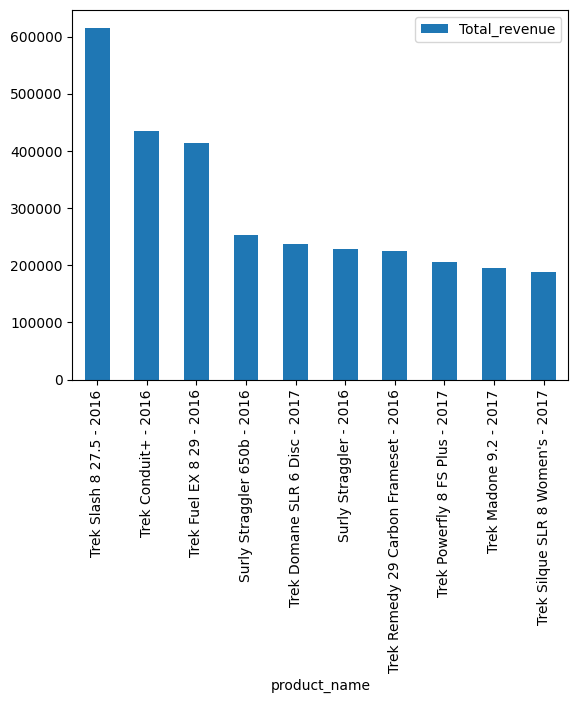

In [7]:
# Insight 5
# Top 10 products (on basis of revenue generation)

Merge1=order_items.merge(products,
                         how='inner',
                         on='product_id').loc[:,['product_name','revenue']]
Revenue_breakdown=Merge1.groupby(['product_name']).agg(Total_revenue=('revenue','sum'))\
                                                  .sort_values('Total_revenue',ascending=False).head(10)

# Required Dataframe
Revenue_breakdown

# Visualisation
Revenue_breakdown.plot(kind='bar')
Revenue_breakdown

,2016,2017,2018
contribution_of,,,
Top 1,17.13,5.72,2.96
Top 3,40.52,14.54,6.92
Top 5,54.57,22.89,10.48
Top 10,74.96,39.91,18.48
Top 20,94.27,61.08,31.60


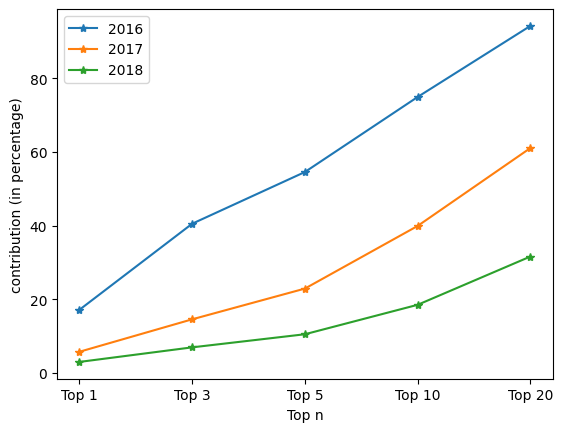

In [6]:
# Insight 6
# Top n products in overall revenue mix by years

# creating function for easier operation
def revenue_contribution (n,year_input):
    # merging orders and order items table to get date, revenue and product data
    Merge1=orders.merge(order_items,
                    how='inner',
                    on='order_id')
    Merge1=Merge1.assign(year=Merge1['order_date'].dt.year)

    # Creating year column
    Merge1=Merge1.loc[:,['year','product_id','revenue']]

    # top n products
    top_n=Merge1[Merge1['year']==year_input].groupby(['product_id']).agg(total_revenue=('revenue','sum'))\
                                             .sort_values('total_revenue',ascending=False).head(n)

    # Yearly revenue
    revenue_for_the_year=Merge1[Merge1['year']==year_input]['revenue'].sum()

    # Top n revenue
    top_n_revenue=top_n['total_revenue'].sum()
    
    # result
    result=((top_n_revenue/revenue_for_the_year)*100).round(2)
    return result

# creation of required dataframe using the function
columns=['contribution_of','2016','2017','2018']
top1=pd.DataFrame([['Top 1',revenue_contribution(1,2016),revenue_contribution(1,2017),revenue_contribution(1,2018)]],columns=columns)
top3=pd.DataFrame([['Top 3',revenue_contribution(3,2016),revenue_contribution(3,2017),revenue_contribution(3,2018)]],columns=columns)
top5=pd.DataFrame([['Top 5',revenue_contribution(5,2016),revenue_contribution(5,2017),revenue_contribution(5,2018)]],columns=columns)
top10=pd.DataFrame([['Top 10',revenue_contribution(10,2016),revenue_contribution(10,2017),revenue_contribution(10,2018)]],columns=columns)
top20=pd.DataFrame([['Top 20',revenue_contribution(20,2016),revenue_contribution(20,2017),revenue_contribution(20,2018)]],columns=columns)

final=pd.concat([top1,top3,top5,top10,top20]).set_index('contribution_of')

# Required Dataframe
final

# Visualisation
plt.plot(final.index,final['2016'],label='2016',marker='*')
plt.plot(final.index,final['2017'],label='2017',marker='*')
plt.plot(final.index,final['2018'],label='2018',marker='*')

plt.xlabel('Top n')
plt.ylabel('contribution (in percentage)')
plt.legend()

final

Note: total brand orders will be more then total number of order ids (as one order can consit of numerous brands)


,Total_revenue,Total_orders,AOV
brand_name,,,
Trek,5129187.52,1235,4153.19
Electra,1343871.73,1729,777.25
Surly,1063039.20,605,1757.09
Sun Bicycles,381842.94,485,787.31
Haro,207060.32,220,941.18
Heller,193782.95,97,1997.76
Pure Cycles,166126.26,258,643.90
Ritchey,88486.02,77,1149.17
Strider,4846.86,16,302.93


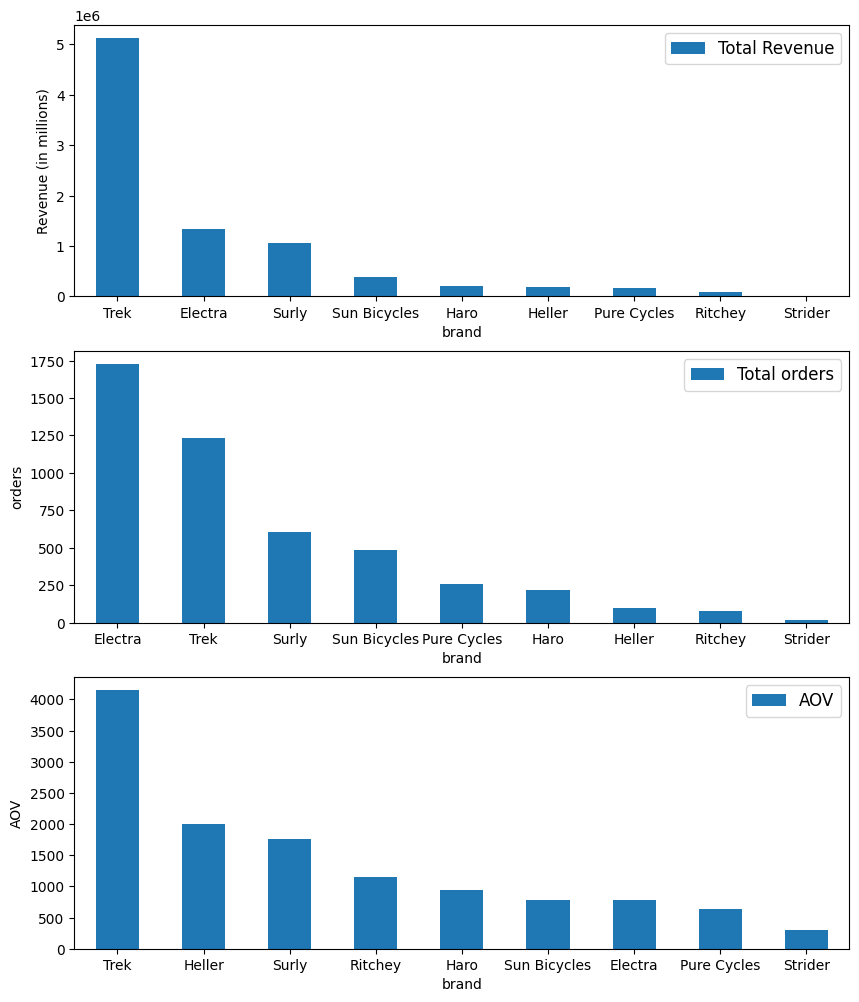

In [7]:
# Insight 7
# Brands by revenue (with total orders and AOV)

# creation of Revenue breakdown dataframe with total orders and AOV by brands
Merge1=order_items.merge(products,
                         how='inner',
                         on='product_id')

Merge2=Merge1.merge(brands,
                    how='inner',
                    on='brand_id').loc[:,['brand_name','revenue']]

Revenue_breakdown=Merge2.groupby(['brand_name']).agg(Total_revenue=('revenue','sum'),
                                                     Total_orders=('brand_name','count'))\
                                                .sort_values('Total_revenue',ascending=False)

# Required dataframe
Revenue_breakdown=Revenue_breakdown.assign(AOV=Revenue_breakdown['Total_revenue']/Revenue_breakdown['Total_orders']).round(2)

# Visualisation
plt.figure(figsize=(10,12))

# Brands by Revenue
plt.subplot(3,1,1)
Revenue_breakdown['Total_revenue'].sort_values(ascending=False).plot(kind='bar',label='Total Revenue')
plt.xlabel('brand')
plt.ylabel('Revenue (in millions)')
plt.xticks(rotation=0)
plt.legend(fontsize=12)

# Brands by orders
plt.subplot(3,1,2)
Revenue_breakdown['Total_orders'].sort_values(ascending=False).plot(kind='bar',label='Total orders')
plt.xlabel('brand')
plt.ylabel('orders')
plt.xticks(rotation=0)
plt.legend(fontsize=12)

# brands by AOV
plt.subplot(3,1,3)
Revenue_breakdown['AOV'].sort_values(ascending=False).plot(kind='bar')   
plt.xlabel('brand')
plt.ylabel('AOV')
plt.xticks(rotation=0)
plt.legend(fontsize=12)

#####
print('Note: total brand orders will be more then total number of order ids (as one order can consit of numerous brands)')
Revenue_breakdown

In [45]:
# Insight 8
# Revenue growth of brands by years

# Merging order items with products and brands to get brand name & revenue data
Merge1=order_items.merge(products,
                         how='inner',
                         on='product_id')

Merge2=Merge1.merge(brands,
                    how='inner',
                    on='brand_id')

# Merging with merge 2 to get order date data
Merge3=Merge2.merge(orders,
                    how='inner',
                    on='order_id')


# Assigning year column
Merge3=Merge3.assign(year=Merge3['order_date'].dt.year).loc[:,['brand_name','revenue','year']]

# grouping by year and brand name
Revenue_breakdown=Merge3.groupby(['year','brand_name'],as_index=False).agg(total_revenue=('revenue','sum'))

# Creation of pivot table
Revenue_breakdown_2=Revenue_breakdown.pivot_table(index='brand_name',
                                                  columns='year',
                                                  values='total_revenue')

# Calculating growth
Revenue_breakdown_2['growth%(16-17)']=((Revenue_breakdown_2[2017]-Revenue_breakdown_2[2016])/Revenue_breakdown_2[2016]*100).round(2)
Revenue_breakdown_2['growth%(16-18)']=((Revenue_breakdown_2[2018]-Revenue_breakdown_2[2016])/Revenue_breakdown_2[2016]*100).round(2)
Revenue_breakdown_2['growth%(17-18)']=((Revenue_breakdown_2[2018]-Revenue_breakdown_2[2017])/Revenue_breakdown_2[2017]*100).round(2)

# Required Dataframe
Final=Revenue_breakdown_2.loc[:,[2016,2017,'growth%(16-17)',2018,'growth%(16-18)','growth%(17-18)']].sort_values(2018,ascending=False)
Final

year,2016,2017,growth%(16-17),2018,growth%(16-18),growth%(17-18)
brand_name,,,,,,
Trek,1286851.42,2448638.44,90.28,1393697.66,8.30,-43.08
Electra,565942.15,407163.64,-28.06,370765.94,-34.49,-8.94
Surly,534432.55,390960.76,-26.85,137645.89,-74.24,-64.79
Sun Bicycles,NaN,329291.43,NaN,52551.51,NaN,-84.04
Haro,NaN,176035.53,NaN,31024.79,NaN,-82.38
Heller,122841.18,46231.04,-62.37,24710.73,-79.88,-46.55
Pure Cycles,128650.36,32617.70,-74.65,4858.20,-96.22,-85.11
Strider,NaN,NaN,NaN,4846.86,NaN,NaN
Ritchey,70489.17,14247.75,-79.79,3749.10,-94.68,-73.69


year,2016,2017,2018
brand_name,,,
Trek,47.50,63.68,68.86
Electra,20.89,10.59,18.32
Surly,19.73,10.17,6.80
Sun Bicycles,0.00,8.56,2.60
Haro,0.00,4.58,1.53
Heller,4.53,1.20,1.22
Pure Cycles,4.75,0.85,0.24
Strider,0.00,0.00,0.24
Ritchey,2.60,0.37,0.19


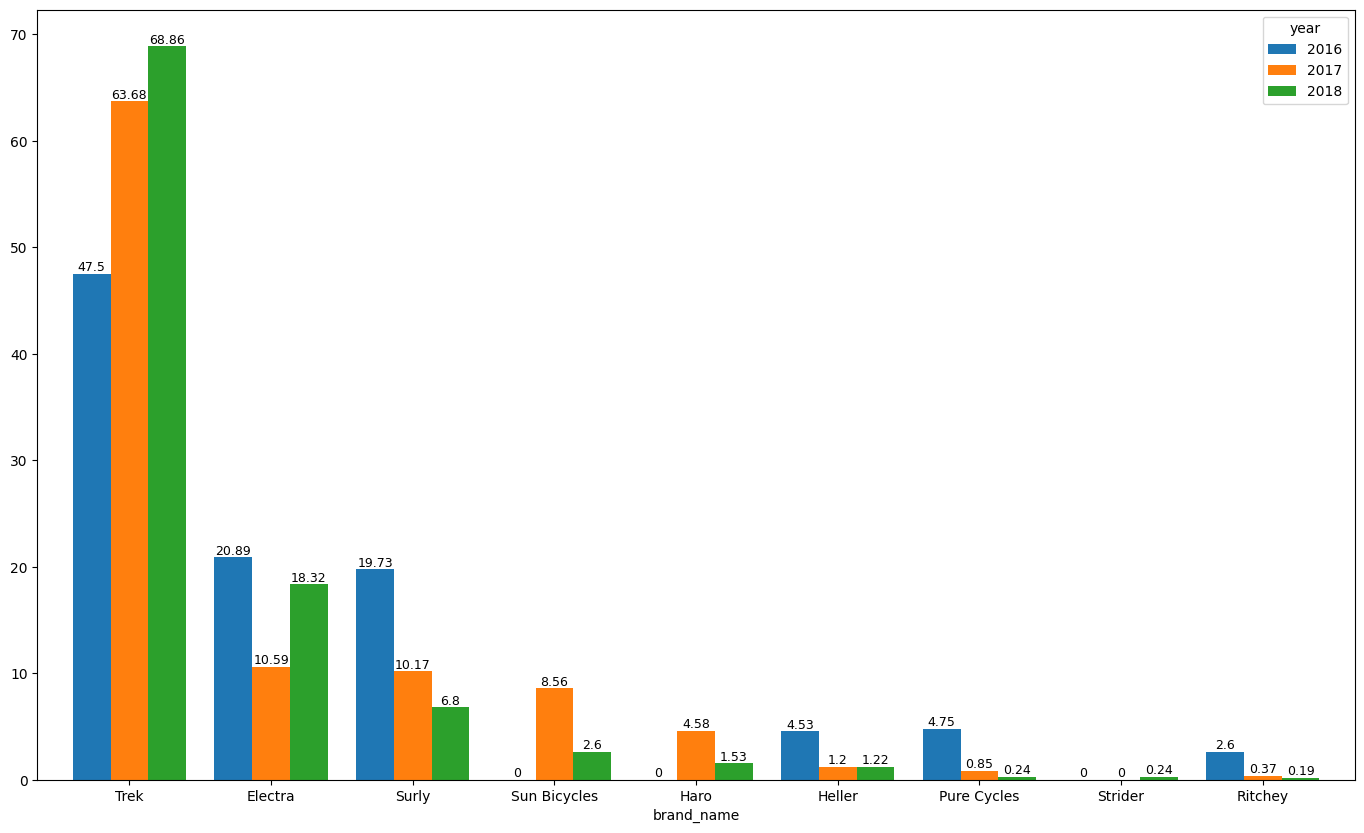

In [52]:
# Insight 9
# Brand Revenue Mix

# Merging order items with products and brands to get brand name & revenue data
Merge1=order_items.merge(products,
                         how='inner',
                         on='product_id')

Merge2=Merge1.merge(brands,
                    how='inner',
                    on='brand_id')

# Merging with merge 2 to get order date data
Merge3=Merge2.merge(orders,
                    how='inner',
                    on='order_id')


# Assigning year column
Merge3=Merge3.assign(year=Merge3['order_date'].dt.year).loc[:,['brand_name','revenue','year']]

# grouping by year and brand name
Revenue_breakdown=Merge3.groupby(['year','brand_name'],as_index=False).agg(total_revenue=('revenue','sum'))

# Creation of pivot table
Revenue_breakdown_2=Revenue_breakdown.pivot_table(index='brand_name',
                                                  columns='year',
                                                  values='total_revenue')

# Total revenue variables
Total_revenue_2016=Revenue_breakdown_2[2016].sum().round(2)
Total_revenue_2017=Revenue_breakdown_2[2017].sum().round(2)
Total_revenue_2018=Revenue_breakdown_2[2018].sum().round(2)

# Revenue contribution
Revenue_breakdown_2[2016]=(Revenue_breakdown_2[2016]/Total_revenue_2016*100).round(2)
Revenue_breakdown_2[2017]=(Revenue_breakdown_2[2017]/Total_revenue_2017*100).round(2)
Revenue_breakdown_2[2018]=(Revenue_breakdown_2[2018]/Total_revenue_2018*100).round(2)

Final=Revenue_breakdown_2.sort_values(2018,ascending=False).fillna(0)

# Required dataframe
Final

# Visualisation
brand_names=Final.index
graph=Final[Final.index.isin(brand_names)].plot(kind='bar',figsize=(17,10),width=0.8)
plt.xticks(rotation=0)

# data labels
for container in graph.containers:
    graph.bar_label(container, label_type='edge', fontsize=9)

Final

In [53]:
# Insight 10
# Top 20 consumers

# Merging customers, orders and order items table for required dataframe
merge1=customers.merge(orders.reset_index(),
                       how='inner',
                       on='customer_id')

merge2=merge1.merge(order_items,
                    how='inner',
                    on='order_id').loc[:,['customer_id','first_name','last_name','revenue']]

merge2=merge2.groupby(['customer_id','first_name','last_name']).agg(total_revenue=('revenue','sum'))

top_20_customers=merge2.reset_index().set_index('customer_id').sort_values('total_revenue',ascending=False).head(20)

# Required dataframe
top_20_customers

,first_name,last_name,total_revenue
customer_id,,,
10,Pamelia,Newman,37799.60
75,Abby,Gamble,37499.27
94,Sharyn,Hopkins,37137.87
6,Lyndsey,Bean,35856.51
16,Emmitt,Sanchez,34502.20
73,Melanie,Hayes,34389.86
1,Debra,Burks,30644.23
61,Elinore,Aguilar,29659.52
93,Corrina,Sawyer,29213.58


,2016,2017,2018
contribution_of,,,
Top 1,0.56,0.76,1.75
Top 5,2.62,3.20,7.27
Top 10,4.95,5.80,13.06
Top 20,9.29,10.72,22.77
Top 50,20.82,23.16,43.76


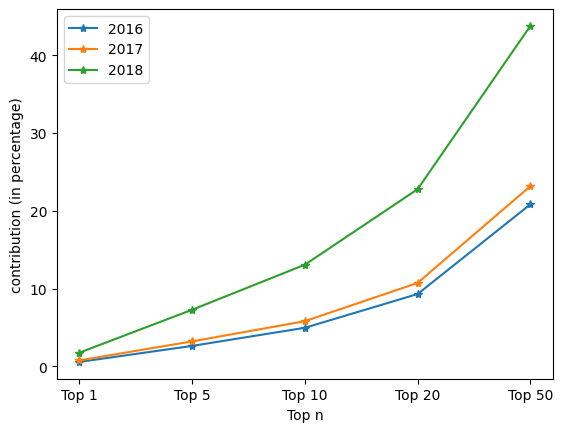

In [25]:
# Insight 11
# contribution by  top 20 customers

def revenue_top_n_customers (n,year_input):

    # merging customers and orders table to get customer and order dates
    merge1=customers.merge(orders.reset_index(),
                   how='inner',
                   on='customer_id')

    # merging merge 1 and order items to get revenue data
    merge2=merge1.merge(order_items,
                        how='inner',
                        on='order_id').loc[:,['customer_id','order_date','revenue']]

    # introducing year column
    merge2=merge2.assign(year=merge2['order_date'].dt.year)

    # grouping to get top n customers
    merge3=merge2.groupby(['year','customer_id']).agg(total_revenue=('revenue','sum')).reset_index()
    merge3=merge3[merge3['year']==year_input].sort_values('total_revenue',ascending=False).head(n)

    # yearly revenue
    yearly_revenue=merge2[merge2['year']==year_input]['revenue'].sum().round(2)

    # revenue by top n
    rev_by_n=merge3['total_revenue'].sum().round(2)

    # result
    result=(rev_by_n/yearly_revenue*100).round(2)
    return result

# creation of required dataframe using the function
columns=['contribution_of','2016','2017','2018']
top1=pd.DataFrame([['Top 1',revenue_top_n_customers(1,2016),revenue_top_n_customers(1,2017),revenue_top_n_customers(1,2018)]],columns=columns)
top5=pd.DataFrame([['Top 5',revenue_top_n_customers(5,2016),revenue_top_n_customers(5,2017),revenue_top_n_customers(5,2018)]],columns=columns)
top10=pd.DataFrame([['Top 10',revenue_top_n_customers(10,2016),revenue_top_n_customers(10,2017),revenue_top_n_customers(10,2018)]],columns=columns)
top20=pd.DataFrame([['Top 20',revenue_top_n_customers(20,2016),revenue_top_n_customers(20,2017),revenue_top_n_customers(20,2018)]],columns=columns)
top50=pd.DataFrame([['Top 50',revenue_top_n_customers(50,2016),revenue_top_n_customers(50,2017),revenue_top_n_customers(50,2018)]],columns=columns)

final=pd.concat([top1,top5,top10,top20,top50]).set_index('contribution_of')

# Required dataframe
final

# Visualisation
plt.plot(final.index,final['2016'],label='2016',marker='*')
plt.plot(final.index,final['2017'],label='2017',marker='*')
plt.plot(final.index,final['2018'],label='2018',marker='*')
plt.xlabel('Top n')
plt.ylabel('contribution (in percentage)')
plt.legend()
final

,Total_revenue,Total_orders,AOV
store_name,,,
Baldwin Bikes,5825734.57,1093,5330.04
Santa Cruz Bikes,1789987.26,348,5143.64
Rowlett Bikes,962521.97,174,5531.74


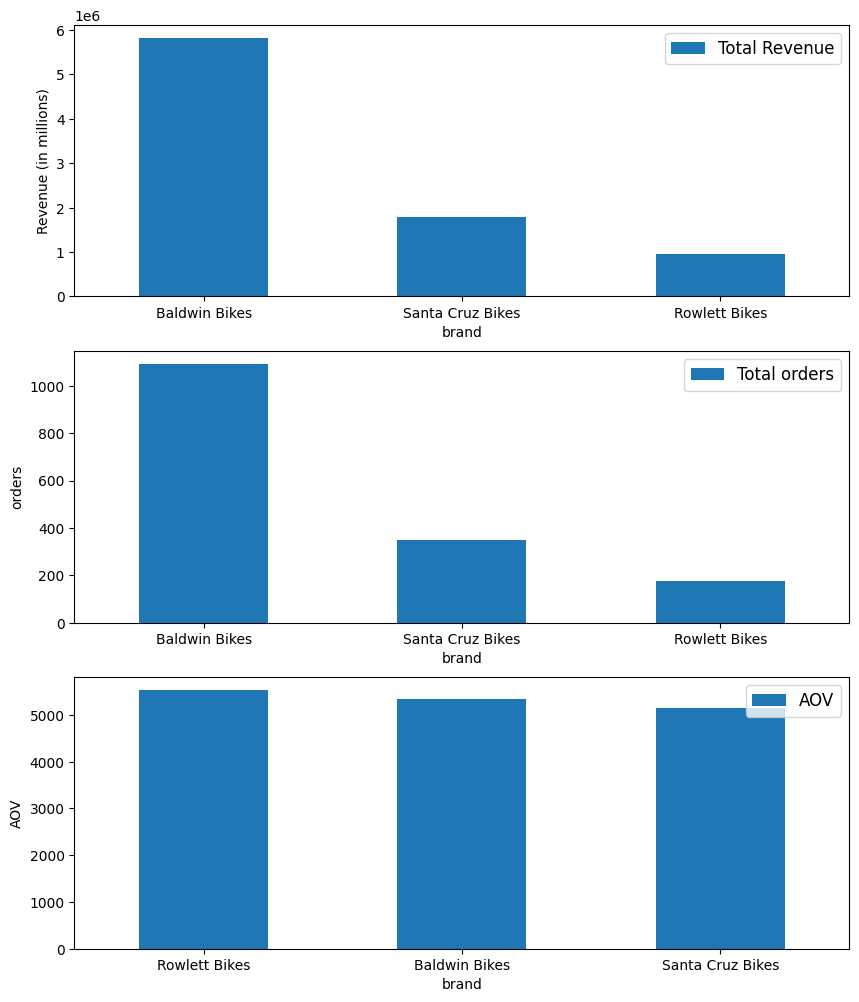

In [26]:
# Insight 12
# Stores by revenue (with total orders and AOV)

# creation of Revenue breakdown dataframe with total orders and AOV by stores
Merge1=stores.merge(orders.reset_index(),
                    how='inner',
                    on='store_id')

Merge2=Merge1.merge(order_items,
                    how='inner',
                    on='order_id').loc[:,['store_name','order_id','revenue']]

Revenue_breakdown=Merge2.groupby(['store_name']).agg(Total_revenue=('revenue','sum'),
                                                     Total_orders=('order_id','nunique'))\
                                                .sort_values('Total_revenue',ascending=False)

# Required dataframe
Revenue_breakdown=Revenue_breakdown.assign(AOV=Revenue_breakdown['Total_revenue']/Revenue_breakdown['Total_orders']).round(2)

# Visualisation
plt.figure(figsize=(10,12))

# stores by Revenue
plt.subplot(3,1,1)
Revenue_breakdown['Total_revenue'].sort_values(ascending=False).plot(kind='bar',label='Total Revenue')
plt.xlabel('brand')
plt.ylabel('Revenue (in millions)')
plt.xticks(rotation=0)
plt.legend(fontsize=12)

# stores by orders
plt.subplot(3,1,2)
Revenue_breakdown['Total_orders'].sort_values(ascending=False).plot(kind='bar',label='Total orders')
plt.xlabel('brand')
plt.ylabel('orders')
plt.xticks(rotation=0)
plt.legend(fontsize=12)

# stores by AOV
plt.subplot(3,1,3)
Revenue_breakdown['AOV'].sort_values(ascending=False).plot(kind='bar')
plt.xlabel('brand')
plt.ylabel('AOV')
plt.xticks(rotation=0)
plt.legend(fontsize=12)
#####
Revenue_breakdown

In [43]:
# Insight 13
# Yearly Revenue growth at stores

# Merging stores & orders table to get order date data
Merge1=stores.merge(orders.reset_index(),
                    how='inner',
                    on='store_id')

# Merging merge 1 with order items to get revenue data
Merge2=Merge1.merge(order_items,
                    how='inner',
                    on='order_id')

# assigning year column
Merge2=Merge2.assign(year=Merge2['order_date'].dt.year).loc[:,['store_name','order_id','revenue','year']]

# grouping by year and store name
Revenue_breakdown=Merge2.groupby(['year','store_name'],as_index=False).agg(total_revenue=('revenue','sum'))

# Creation of pivot table
Revenue_breakdown_2=Revenue_breakdown.pivot_table(index='store_name',
                                                  columns='year',
                                                  values='total_revenue')

# Calculating growth
Revenue_breakdown_2['growth%(16-17)']=((Revenue_breakdown_2[2017]-Revenue_breakdown_2[2016])/Revenue_breakdown_2[2016]*100).round(2)
Revenue_breakdown_2['growth%(16-18)']=((Revenue_breakdown_2[2018]-Revenue_breakdown_2[2016])/Revenue_breakdown_2[2016]*100).round(2)
Revenue_breakdown_2['growth%(17-18)']=((Revenue_breakdown_2[2018]-Revenue_breakdown_2[2017])/Revenue_breakdown_2[2017]*100).round(2)

# Required Dataframe
Final=Revenue_breakdown_2.loc[:,[2016,2017,'growth%(16-17)',2018,'growth%(16-18)','growth%(17-18)']].sort_values(2018,ascending=False)
Final

year,2016,2017,growth%(16-17),2018,growth%(16-18),growth%(17-18)
store_name,,,,,,
Baldwin Bikes,1780938.70,2764237.03,55.21,1280558.84,-28.10,-53.67
Santa Cruz Bikes,628887.33,630020.13,0.18,531079.80,-15.55,-15.70
Rowlett Bikes,299380.80,450929.13,50.62,212212.04,-29.12,-52.94


year,2016,2017,2018
store_name,,,
Baldwin Bikes,65.74,71.89,63.27
Santa Cruz Bikes,23.21,16.38,26.24
Rowlett Bikes,11.05,11.73,10.49


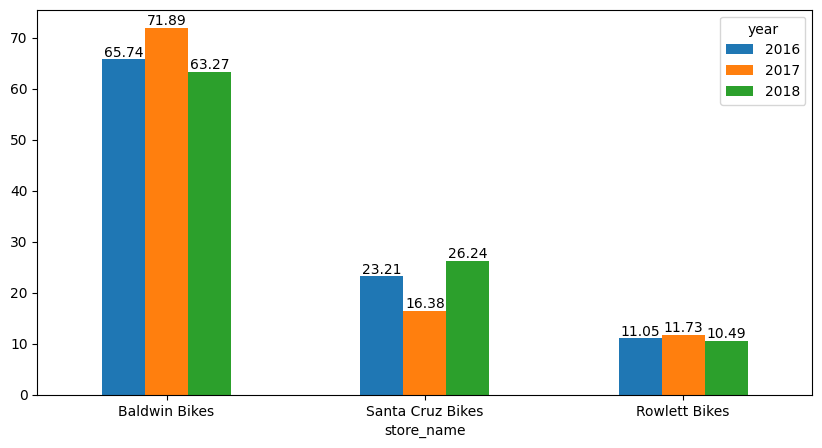

In [45]:
# Insight 14
# Store Revenue Mix

# Merging stores & orders table to get order date data
Merge1=stores.merge(orders.reset_index(),
                    how='inner',
                    on='store_id')

# Merging merge 1 with order items to get revenue data
Merge2=Merge1.merge(order_items,
                    how='inner',
                    on='order_id')

# assigning year column
Merge2=Merge2.assign(year=Merge2['order_date'].dt.year).loc[:,['store_name','order_id','revenue','year']]

# grouping by year and store name
Revenue_breakdown=Merge2.groupby(['year','store_name'],as_index=False).agg(total_revenue=('revenue','sum'))

# Creation of pivot table
Revenue_breakdown_2=Revenue_breakdown.pivot_table(index='store_name',
                                                  columns='year',
                                                  values='total_revenue')


# Total revenue variables
Total_revenue_2016=Revenue_breakdown_2[2016].sum().round(2)
Total_revenue_2017=Revenue_breakdown_2[2017].sum().round(2)
Total_revenue_2018=Revenue_breakdown_2[2018].sum().round(2)

# Revenue contribution
Revenue_breakdown_2[2016]=(Revenue_breakdown_2[2016]/Total_revenue_2016*100).round(2)
Revenue_breakdown_2[2017]=(Revenue_breakdown_2[2017]/Total_revenue_2017*100).round(2)
Revenue_breakdown_2[2018]=(Revenue_breakdown_2[2018]/Total_revenue_2018*100).round(2)

# Required dataframe
Final=Revenue_breakdown_2.sort_values(2018,ascending=False).fillna(0)

# Visualisation
brand_names=Final.index
graph=Final[Final.index.isin(brand_names)].plot(kind='bar',figsize=(10,5))

# data labels
for container in graph.containers:
    graph.bar_label(container, label_type='edge', fontsize=10)
plt.xticks(rotation=0)

Final

Note: total category orders will be more then total number of order ids (as one order can consit of numerous categories)


,Total_revenue,Total_orders,AOV
category_name,,,
Mountain Bikes,3030590.90,1183,2561.78
Road Bikes,1852497.33,374,4953.20
Cruisers Bicycles,1108936.83,1378,804.74
Electric Bikes,1020203.85,212,4812.28
Cyclocross Bicycles,799831.44,256,3124.34
Comfort Bicycles,438424.06,537,816.43
Children Bicycles,327759.39,782,419.13


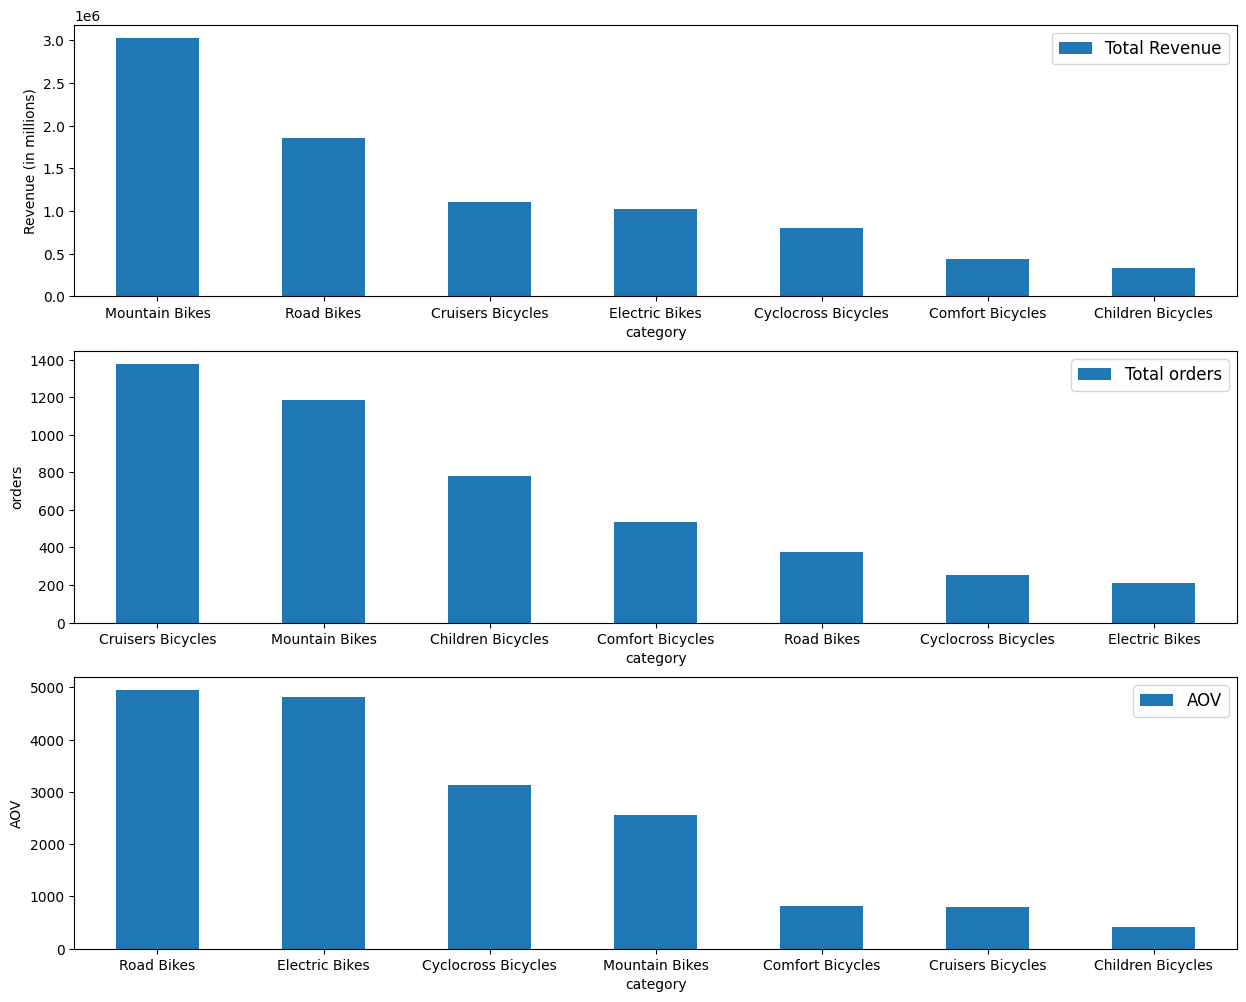

In [40]:
# Insight 15
# categories by revenue (with total orders and AOV)

# creation of Revenue breakdown dataframe with total orders and AOV by categories
Merge1=order_items.merge(products,
                         how='inner',
                         on='product_id')

Merge2=Merge1.merge(categories,
                    how='inner',
                    on='category_id').loc[:,['category_name','revenue']]

Revenue_breakdown=Merge2.groupby(['category_name']).agg(Total_revenue=('revenue','sum'),
                                                        Total_orders=('category_name','count'))\
                                                   .sort_values('Total_revenue',ascending=False)

# Required dataframe
Revenue_breakdown=Revenue_breakdown.assign(AOV=Revenue_breakdown['Total_revenue']/Revenue_breakdown['Total_orders']).round(2)

# Visualisation
plt.figure(figsize=(15,12))

# category by Revenue
plt.subplot(3,1,1)
Revenue_breakdown['Total_revenue'].sort_values(ascending=False).plot(kind='bar',label='Total Revenue')
plt.xlabel('category')
plt.ylabel('Revenue (in millions)')
plt.xticks(rotation=0)
plt.legend(fontsize=12)

# category by orders
plt.subplot(3,1,2)
Revenue_breakdown['Total_orders'].sort_values(ascending=False).plot(kind='bar',label='Total orders')
plt.xlabel('category')
plt.ylabel('orders')
plt.xticks(rotation=0)
plt.legend(fontsize=12)

# category by AOV
plt.subplot(3,1,3)
Revenue_breakdown['AOV'].sort_values(ascending=False).plot(kind='bar')
plt.xlabel('category')
plt.ylabel('AOV')
plt.xticks(rotation=0)
plt.legend(fontsize=12)
#####
print('Note: total category orders will be more then total number of order ids (as one order can consit of numerous categories)')
Revenue_breakdown

In [50]:
# Insight 16
# Revenue growth of category by years

# Merging order items with products and categories to get category name & revenue data
Merge1=order_items.merge(products,
                         how='inner',
                         on='product_id')

Merge2=Merge1.merge(categories,
                    how='inner',
                    on='category_id')

# Merging with merge 2 to get order date data
Merge3=Merge2.merge(orders,
                    how='inner',
                    on='order_id')


# Assigning year column
Merge3=Merge3.assign(year=Merge3['order_date'].dt.year).loc[:,['category_name','revenue','year']]

# grouping by year and brand name
Revenue_breakdown=Merge3.groupby(['year','category_name'],as_index=False).agg(total_revenue=('revenue','sum'))

# Creation of pivot table
Revenue_breakdown_2=Revenue_breakdown.pivot_table(index='category_name',
                                                  columns='year',
                                                  values='total_revenue')

# Calculating growth
Revenue_breakdown_2['growth%(16-17)']=((Revenue_breakdown_2[2017]-Revenue_breakdown_2[2016])/Revenue_breakdown_2[2016]*100).round(2)
Revenue_breakdown_2['growth%(16-18)']=((Revenue_breakdown_2[2018]-Revenue_breakdown_2[2016])/Revenue_breakdown_2[2016]*100).round(2)
Revenue_breakdown_2['growth%(17-18)']=((Revenue_breakdown_2[2018]-Revenue_breakdown_2[2017])/Revenue_breakdown_2[2017]*100).round(2)

# Required Dataframe
Final=Revenue_breakdown_2.loc[:,[2016,2017,'growth%(16-17)',2018,'growth%(16-18)','growth%(17-18)']].sort_values(2018,ascending=False)
Final

year,2016,2017,growth%(16-17),2018,growth%(16-18),growth%(17-18)
category_name,,,,,,
Road Bikes,NaN,1161417.03,NaN,691080.30,NaN,-40.50
Mountain Bikes,1326687.74,1252213.92,-5.61,451689.24,-65.95,-63.93
Electric Bikes,311988.35,324548.64,4.03,383666.86,22.97,18.22
Cruisers Bicycles,425546.40,424809.07,-0.17,258581.36,-39.24,-39.13
Cyclocross Bicycles,375938.23,331643.43,-11.78,92249.78,-75.46,-72.18
Comfort Bicycles,171016.57,185245.94,8.32,82161.55,-51.96,-55.65
Children Bicycles,98029.54,165308.26,68.63,64421.59,-34.28,-61.03


year,2016,2017,2018
category_name,,,
Road Bikes,0.00,30.20,34.15
Mountain Bikes,48.97,32.57,22.32
Electric Bikes,11.52,8.44,18.96
Cruisers Bicycles,15.71,11.05,12.78
Cyclocross Bicycles,13.88,8.62,4.56
Comfort Bicycles,6.31,4.82,4.06
Children Bicycles,3.62,4.30,3.18


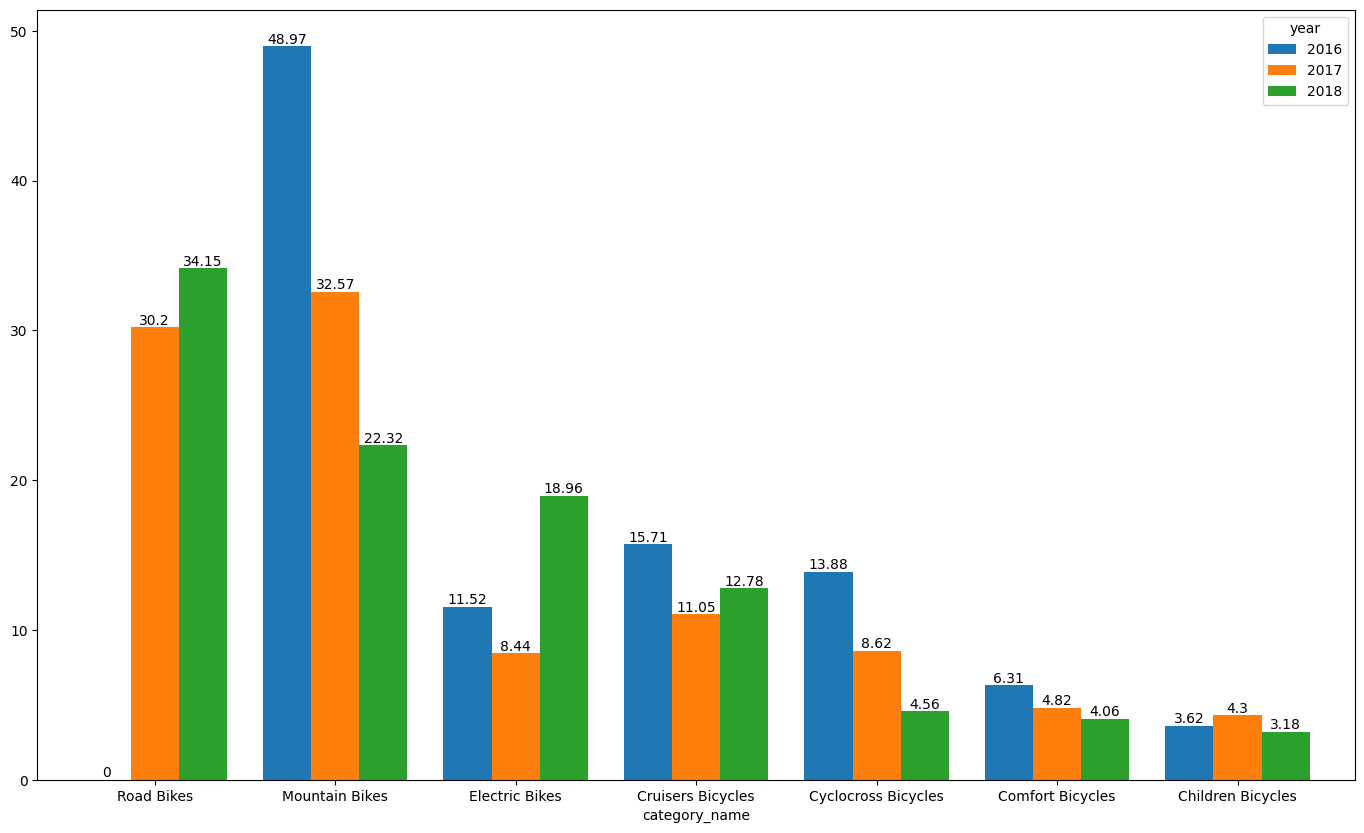

In [49]:
# Insight 17
# Categories Revenue Mix

# Merging order items with products and categories to get category name & revenue data
Merge1=order_items.merge(products,
                         how='inner',
                         on='product_id')

Merge2=Merge1.merge(categories,
                    how='inner',
                    on='category_id')

# Merging with merge 2 to get order date data
Merge3=Merge2.merge(orders,
                    how='inner',
                    on='order_id')


# Assigning year column
Merge3=Merge3.assign(year=Merge3['order_date'].dt.year).loc[:,['category_name','revenue','year']]

# grouping by year and brand name
Revenue_breakdown=Merge3.groupby(['year','category_name'],as_index=False).agg(total_revenue=('revenue','sum'))

# Creation of pivot table
Revenue_breakdown_2=Revenue_breakdown.pivot_table(index='category_name',
                                                  columns='year',
                                                  values='total_revenue')


# Total revenue variables
Total_revenue_2016=Revenue_breakdown_2[2016].sum().round(2)
Total_revenue_2017=Revenue_breakdown_2[2017].sum().round(2)
Total_revenue_2018=Revenue_breakdown_2[2018].sum().round(2)

# Revenue contribution
Revenue_breakdown_2[2016]=(Revenue_breakdown_2[2016]/Total_revenue_2016*100).round(2)
Revenue_breakdown_2[2017]=(Revenue_breakdown_2[2017]/Total_revenue_2017*100).round(2)
Revenue_breakdown_2[2018]=(Revenue_breakdown_2[2018]/Total_revenue_2018*100).round(2)

# Required dataframe
Final=Revenue_breakdown_2.sort_values(2018,ascending=False).fillna(0)

# Visualisation
category_names=Final.index
graph=Final[Final.index.isin(category_names)].plot(kind='bar',figsize=(17,10),width=0.8)

# data labels
for container in graph.containers:
    graph.bar_label(container, label_type='edge', fontsize=10)
plt.xticks(rotation=0)

Final

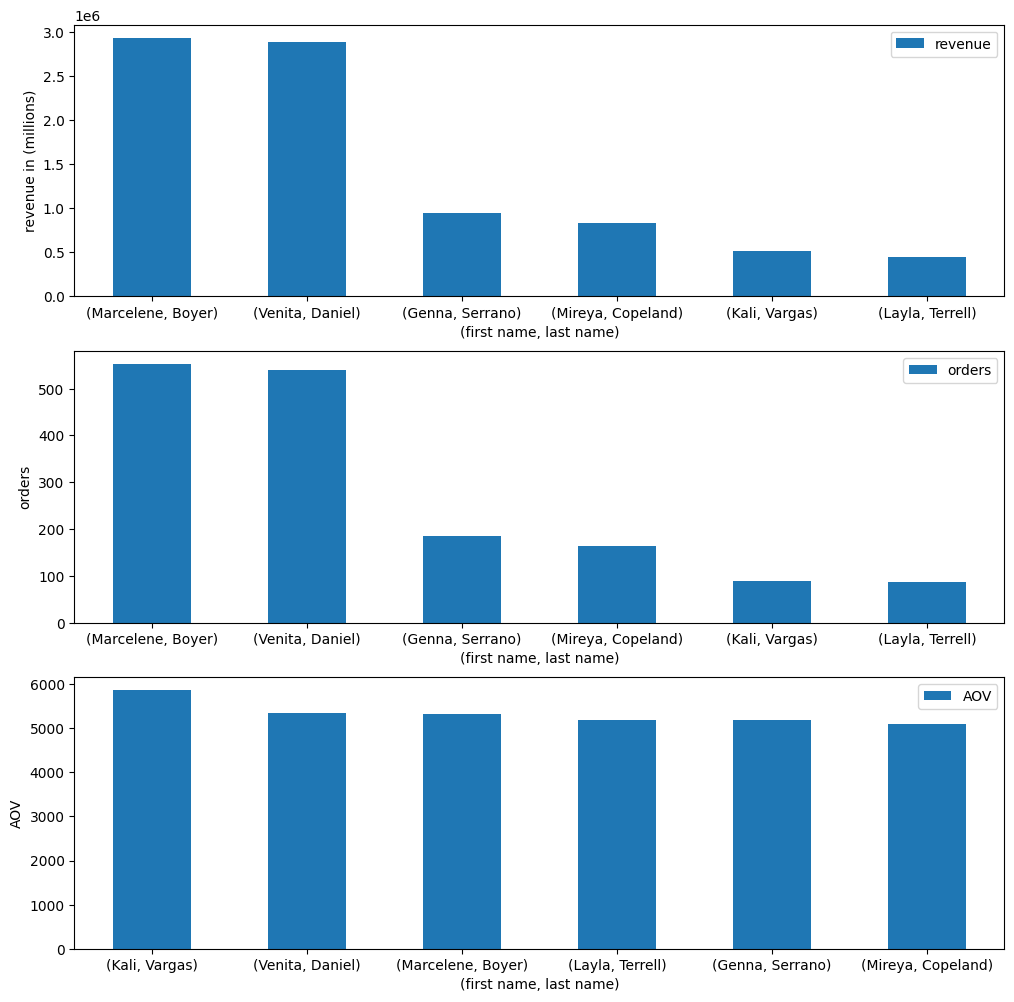

In [36]:
# Insight 8
# Best performers

# Merging orders, order items and staff to get order id, revenue, staff data
Merge1=orders.merge(order_items,
                    how='inner',
                    on='order_id')

Merge2=Merge1.merge(staffs,
                    how='right',
                    on='staff_id').loc[:,['staff_id','order_id','first_name','last_name','revenue']]

# Grouping by staff id, first name, last name
Merge2=Merge2.groupby(['staff_id','first_name','last_name']).agg(total_revenue=('revenue','sum'),
                                                                 total_orders=('order_id','nunique'))

# Adding AOV column
Merge2=Merge2.assign(AOV=(Merge2['total_revenue']/Merge2['total_orders']).round(2)).fillna(0)

# Sorting by total revenue
Final=Merge2.sort_values('total_revenue',ascending=False)

# Required Dataframe
Final

# Visualisation
plt.figure(figsize=(12,12))
Final_2=Final.reset_index()

# Staff by revenue
plt.subplot(3,1,1)
Final_2[Final_2['total_revenue']!=0].set_index(['first_name','last_name'])['total_revenue']\
                                    .sort_values(ascending=False).plot(kind='bar',label='revenue')

plt.xlabel('(first name, last name)')
plt.xticks(rotation=0)
plt.ylabel('revenue in (millions)')
plt.legend()

# Staff by orders
plt.subplot(3,1,2)
Final_2[Final_2['total_orders']!=0].set_index(['first_name','last_name'])['total_orders']\
                                    .sort_values(ascending=False).plot(kind='bar',label='orders')

plt.xlabel('(first name, last name)')
plt.xticks(rotation=0)
plt.ylabel('orders')
plt.legend()

# Staff by AOV
plt.subplot(3,1,3)
Final_2[Final_2['AOV']!=0].set_index(['first_name','last_name'])['AOV']\
                                    .sort_values(ascending=False).plot(kind='bar',label='AOV')

plt.xlabel('(first name, last name)')
plt.xticks(rotation=0)
plt.ylabel('AOV')
plt.legend()